In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertTokenizer
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
dataset = load_dataset("imdb")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset['train']['text'],
                                                                    dataset['train']['label'],
                                                                    test_size=0.1,stratify = dataset['train']['label'])

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_dataset = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
val_dataset = tokenizer(val_texts, padding=True, truncation=True, max_length=128)
test_dataset = tokenizer(dataset['test']['text'], padding=True, truncation=True, max_length=128)

In [ ]:
input_ids_train = torch.tensor(train_dataset['input_ids'])
attention_masks_train = torch.tensor(train_dataset['attention_mask'])
labels_train = torch.tensor(train_labels)
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

input_ids_val = torch.tensor(val_dataset['input_ids'])
attention_masks_val = torch.tensor(val_dataset['attention_mask'])
labels_val = torch.tensor(val_labels)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

input_ids_test = torch.tensor(test_dataset['input_ids'])
attention_masks_test = torch.tensor(test_dataset['attention_mask'])
labels_test = torch.tensor(dataset['test']['label'])
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr = 1e-5,correct_bias=False)
criterion = nn.CrossEntropyLoss()

num_epochs = 8
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= 0, num_training_steps=total_steps)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
train_loss = []
train_accuracies = []
val_loss = []
val_accuracies = []

for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_dataloader)
    train_loss.append(avg_loss)
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_accuracy = correct_val_predictions / total_val_predictions
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/8, Training Loss: 0.3395, Validation Loss: 0.3257, Training Accuracy: 0.8463, Validation Accuracy: 0.8628
Epoch 2/8, Training Loss: 0.2137, Validation Loss: 0.3550, Training Accuracy: 0.9147, Validation Accuracy: 0.8708
Epoch 3/8, Training Loss: 0.1309, Validation Loss: 0.4089, Training Accuracy: 0.9520, Validation Accuracy: 0.8604
Epoch 4/8, Training Loss: 0.0768, Validation Loss: 0.5179, Training Accuracy: 0.9744, Validation Accuracy: 0.8632
Epoch 5/8, Training Loss: 0.0484, Validation Loss: 0.5643, Training Accuracy: 0.9850, Validation Accuracy: 0.8612
Epoch 6/8, Training Loss: 0.0311, Validation Loss: 0.6717, Training Accuracy: 0.9914, Validation Accuracy: 0.8612
Epoch 7/8, Training Loss: 0.0212, Validation Loss: 0.6763, Training Accuracy: 0.9944, Validation Accuracy: 0.8592


In [ ]:
model.eval()
correct_predictions_test = 0
total_predictions_test = 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    _, predicted_test = torch.max(logits, 1)
    correct_predictions_test += (predicted_test == labels).sum().item()
    total_predictions_test += labels.size(0)

test_accuracy = correct_predictions_test / total_predictions_test

print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.87284


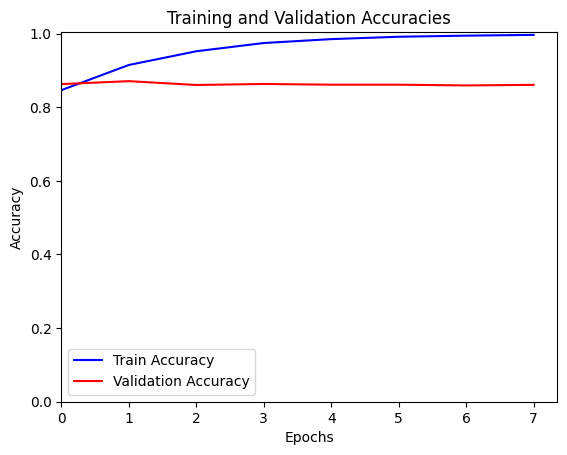

In [ ]:
epochs = range(0, len(train_accuracies))
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()